In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:

df = pd.read_csv("fetal_health.csv")


In [ ]:

X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().astype(int)


In [ ]:

print("Original Class Distribution:", Counter(y))


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


y_resampled = y_resampled.astype(int)


print("After SMOTE Class Distribution:", Counter(y_resampled))


Original Class Distribution: Counter({1: 1655, 2: 295, 3: 176})
After SMOTE Class Distribution: Counter({2: 1655, 1: 1655, 3: 1655})


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [ ]:

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class ManualDecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        unique_classes = np.unique(y)

        if depth >= self.max_depth or len(unique_classes) == 1 or num_samples < self.min_samples_split:
            return Node(value=Counter(y).most_common(1)[0][0])

        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return Node(value=Counter(y).most_common(1)[0][0])

        left_idx = X[:, best_feature] <= best_threshold
        right_idx = X[:, best_feature] > best_threshold

        left_subtree = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_subtree = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return Node(feature=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

    def _best_split(self, X, y):
        best_gain = -1
        best_feature, best_threshold = None, None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_idx = X[:, feature] <= threshold
                right_idx = X[:, feature] > threshold
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                gain = self._information_gain(y, y[left_idx], y[right_idx])
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def _entropy(self, y):
       values, counts = np.unique(y, return_counts=True)
       probabilities = counts / len(y)
       return -np.sum(probabilities * np.log2(probabilities + 1e-9))


    def _information_gain(self, y, y_left, y_right):
        return self._entropy(y) - (len(y_left) / len(y) * self._entropy(y_left) + len(y_right) / len(y) * self._entropy(y_right))

    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])

    def _predict(self, x, node):
        if node.value is not None:
            return node.value
        return self._predict(x, node.left if x[node.feature] <= node.threshold else node.right)


In [ ]:

class ManualKNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            k_neighbors = np.argsort(distances)[:self.k]
            labels = [self.y_train[i] for i in k_neighbors]
            predictions.append(Counter(labels).most_common(1)[0][0])
        return np.array(predictions)


In [ ]:

class ManualRandomForest:
    def __init__(self, n_trees=10, max_depth=5, min_samples_split=2):
        self.n_trees = n_trees
        self.trees = [ManualDecisionTree(max_depth, min_samples_split) for _ in range(n_trees)]

    def fit(self, X, y):
        for tree in self.trees:
            idxs = np.random.choice(len(X), len(X), replace=True)
            tree.fit(X[idxs], y[idxs])

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)


In [ ]:

class ManualGradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []

    def fit(self, X, y):
        residuals = y.astype(np.float64)
        for _ in range(self.n_estimators):
            tree = ManualDecisionTree(max_depth=7)
            tree.fit(X, residuals)
            self.models.append(tree)
            residuals -= self.learning_rate * tree.predict(X)
    def predict(self, X):
        preds = np.sum([self.learning_rate * tree.predict(X) for tree in self.models], axis=0)
        return np.round(preds).astype(int)

In [ ]:
class ManualXGBoost:
    def __init__(self, n_estimators=200, learning_rate=0.05, max_depth=5):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []

    def fit(self, X, y):
        predictions = np.zeros(len(y))
        for _ in range(self.n_estimators):
            residuals = y - predictions
            tree = ManualDecisionTree(max_depth=self.max_depth)
            tree.fit(X, residuals)
            self.models.append(tree)
            predictions += self.learning_rate * tree.predict(X)

    def predict(self, X):
        preds = np.sum([self.learning_rate * tree.predict(X) for tree in self.models], axis=0)
        return np.round(preds).astype(int)

In [ ]:

models = {

    "KNN": ManualKNN(k=5),
    "Random Forest": ManualRandomForest(),
    "Gradient Boosting": ManualGradientBoosting(),
    "XGBoost": ManualXGBoost()
}



KNN - Accuracy: 93.66%
              precision    recall  f1-score   support

           1       0.98      0.86      0.92       353
           2       0.86      0.97      0.91       317
           3       0.98      0.99      0.98       323

    accuracy                           0.94       993
   macro avg       0.94      0.94      0.94       993
weighted avg       0.94      0.94      0.94       993



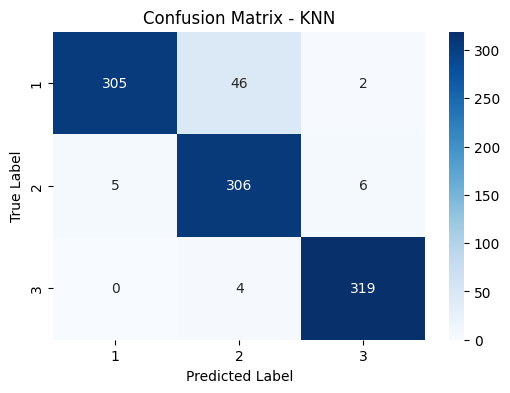


Random Forest - Accuracy: 90.03%
              precision    recall  f1-score   support

           1       0.89      0.89      0.89       353
           2       0.86      0.85      0.86       317
           3       0.95      0.96      0.95       323

    accuracy                           0.90       993
   macro avg       0.90      0.90      0.90       993
weighted avg       0.90      0.90      0.90       993



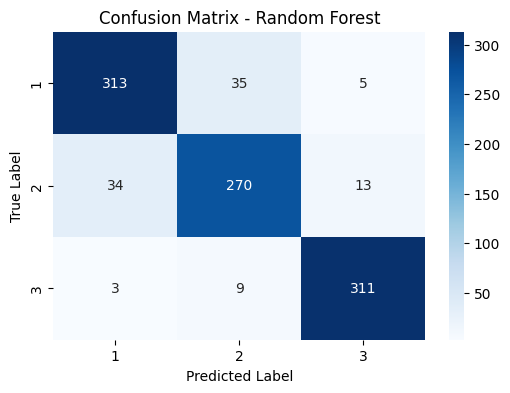


Gradient Boosting - Accuracy: 93.25%
              precision    recall  f1-score   support

           1       0.96      0.91      0.93       353
           2       0.86      0.95      0.90       317
           3       0.99      0.94      0.96       323

    accuracy                           0.93       993
   macro avg       0.94      0.93      0.93       993
weighted avg       0.94      0.93      0.93       993



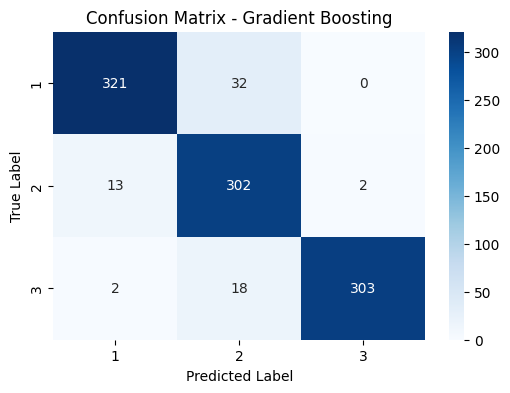


XGBoost - Accuracy: 92.04%
              precision    recall  f1-score   support

           1       0.90      0.89      0.90       353
           2       0.87      0.90      0.88       317
           3       0.99      0.98      0.98       323

    accuracy                           0.92       993
   macro avg       0.92      0.92      0.92       993
weighted avg       0.92      0.92      0.92       993



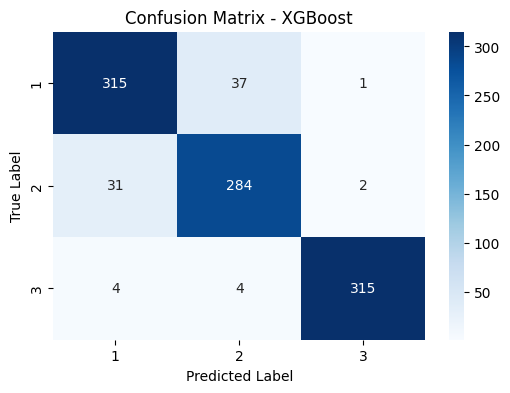

In [ ]:
predictions = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred
    print(f"\n{name} - Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(classification_report(y_test, y_pred))


    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


Voting Ensemble - Accuracy: 91.14%
              precision    recall  f1-score   support

           1       1.00      0.82      0.90       353
           2       0.84      0.93      0.88       317
           3       0.90      0.99      0.95       323

    accuracy                           0.91       993
   macro avg       0.92      0.91      0.91       993
weighted avg       0.92      0.91      0.91       993



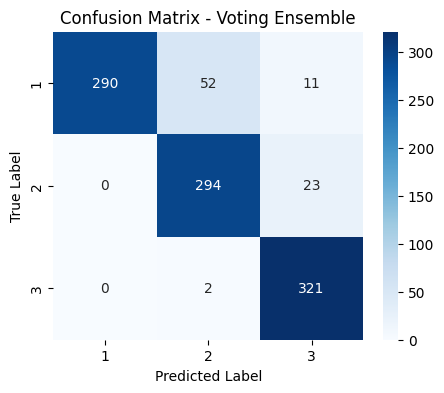

In [ ]:
class VotingEnsemble:
    def __init__(self, models, known_classes):
        self.models = models
        self.known_classes = set(known_classes)

    def fit(self, X, y):
        for model in self.models.values():
            model.fit(X, y)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models.values()])
        final_predictions = np.apply_along_axis(lambda x: self.majority_vote(x), axis=0, arr=predictions)
        return final_predictions

    def majority_vote(self, predictions):
        counter = Counter(predictions)
        most_common_label, _ = counter.most_common(1)[0]


        return most_common_label if most_common_label in self.known_classes else max(self.known_classes)


known_classes = [1, 2, 3]
ensemble_model = VotingEnsemble(models, known_classes)
ensemble_model.fit(X_train_scaled, y_train)


y_pred_ensemble = ensemble_model.predict(X_test_scaled)


print("\nVoting Ensemble - Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_ensemble) * 100))
print(classification_report(y_test, y_pred_ensemble, zero_division=1))


plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_ensemble), annot=True, fmt="d", cmap="Blues", xticklabels=known_classes, yticklabels=known_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Voting Ensemble")
plt.show()


In [ ]:
new_data_class_2 = pd.DataFrame({
    'baseline value': [120],
    'accelerations': [0],
    'fetal_movement': [0],
    'uterine_contractions': [0],
    'light_decelerations': [0],
    'severe_decelerations': [0],
    'prolongued_decelerations': [0],
    'abnormal_short_term_variability': [73],
    'mean_value_of_short_term_variability': [0.5],
    'percentage_of_time_with_abnormal_long_term_variability': [43],
    'mean_value_of_long_term_variability': [2.4],
    'histogram_width': [64],
    'histogram_min': [62],
    'histogram_max': [126],
    'histogram_number_of_peaks': [2],
    'histogram_number_of_zeroes': [0],
    'histogram_mode': [120],
    'histogram_mean': [137],
    'histogram_median': [121],
    'histogram_variance': [73],
    'histogram_tendency': [1]
})

class_labels = {1: 'Normal', 2: 'Suspect', 3: 'Pathological'}


new_data_scaled = scaler.transform(new_data_class_2.to_numpy())


model_predictions = []
for name, model in models.items():
    pred = model.predict(new_data_scaled)
    model_predictions.append(pred[0])


final_prediction = Counter(model_predictions).most_common(1)[0][0]


predicted_class_name = class_labels[final_prediction]


print(f"Predicted Class Number: {final_prediction}")
print(f"Predicted Class Name: {predicted_class_name}")




Predicted Class Number: 2
Predicted Class Name: Suspect


In [ ]:
new_data_class_2 = pd.DataFrame({
    'baseline value': [133],
    'accelerations': [0.003],
    'fetal_movement': [0],
    'uterine_contractions': [0.008],
    'light_decelerations': [0.003],
    'severe_decelerations': [0],
    'prolongued_decelerations': [0],
    'abnormal_short_term_variability': [16],
    'mean_value_of_short_term_variability': [2.1],
    'percentage_of_time_with_abnormal_long_term_variability': [0],
    'mean_value_of_long_term_variability': [13.4],
    'histogram_width': [130],
    'histogram_min': [68],
    'histogram_max': [198],
    'histogram_number_of_peaks': [5],
    'histogram_number_of_zeroes': [1],
    'histogram_mode': [141],
    'histogram_mean': [135],
    'histogram_median': [138],
    'histogram_variance': [13],
    'histogram_tendency': [0]
})

class_labels = {1: 'Normal', 2: 'Suspect', 3: 'Pathological'}


new_data_scaled = scaler.transform(new_data_class_2.to_numpy())


model_predictions = []
for name, model in models.items():
    pred = model.predict(new_data_scaled)
    model_predictions.append(pred[0])


final_prediction = Counter(model_predictions).most_common(1)[0][0]


predicted_class_name = class_labels[final_prediction]


print(f"Predicted Class Number: {final_prediction}")
print(f"Predicted Class Name: {predicted_class_name}")




Predicted Class Number: 1
Predicted Class Name: Normal


In [ ]:
new_data_class_2 = pd.DataFrame({
    'baseline value': [134],
    'accelerations': [0.001],
    'fetal_movement': [0],
    'uterine_contractions': [0.013],
    'light_decelerations': [0.008],
    'severe_decelerations': [0],
    'prolongued_decelerations': [0.003],
    'abnormal_short_term_variability': [29],
    'mean_value_of_short_term_variability': [6.3],
    'percentage_of_time_with_abnormal_long_term_variability': [0],
    'mean_value_of_long_term_variability': [0],
    'histogram_width': [150],
    'histogram_min': [50],
    'histogram_max': [200],
    'histogram_number_of_peaks': [6],
    'histogram_number_of_zeroes': [3],
    'histogram_mode': [71],
    'histogram_mean': [107],
    'histogram_median': [106],
    'histogram_variance': [215],
    'histogram_tendency': [0]
})

class_labels = {1: 'Normal', 2: 'Suspect', 3: 'Pathological'}


new_data_scaled = scaler.transform(new_data_class_2.to_numpy())


model_predictions = []
for name, model in models.items():
    pred = model.predict(new_data_scaled)
    model_predictions.append(pred[0])


final_prediction = Counter(model_predictions).most_common(1)[0][0]


predicted_class_name = class_labels[final_prediction]


print(f"Predicted Class Number: {final_prediction}")
print(f"Predicted Class Name: {predicted_class_name}")




Predicted Class Number: 3
Predicted Class Name: Pathological
